In [31]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold # cross_validation -> model_selection

## Feature Exploration, Engineering and Cleaning

In [32]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test['PassengerId'] # 캐글 제출할 때 필요한 피처

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [33]:
full_data = [train, test]

# 이름 길이 피처를 새로 생성
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Cabin 정보 유무 피처를 새로 생성
# Cabin 정보가 있으면 1 없으면 0
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 가족 인원수 피처를 새로 생성
# 가족 인원수: 본인 + 형제/자매(SibSp) + 부모/자식(Parch)
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Embarked 결측치는 s 로 채움
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Fare의 결측치는 train의 Fare 중앙값으로 채움
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Age의 결측치는 평균, 표준편차 내의 랜덤 값으로 채움
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# 범주형 피처 만들기( 나이, 요금 )
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 이름에서 Mr, Miss, Mrs 등의 직함(Title)을 추출
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# 희귀 직함들을 Rare로 묶고, 비슷한 직함 통합
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace([...], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# 범주형 데이터를 숫자로 변환
for dataset in full_data:
    # 성별: female -> 0, male -> 1
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # 직함 Title: 숫자 매핑
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # 탑승지 Embarked: S -> 0, C -> 1, Q -> 2
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Fare를 4개의 구간으로 나눠서 0~3 범주로 변환
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Age도 5개의 구간으로 나눔
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [34]:
# 필요없는 피처 제거
# PassengerId -> 모델 학습 및 예측에는 포함하지 않도록 drop
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Visualisations

In [35]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0
3,1,1,0,2,0,3,0,44,1,2,0,3.0
4,0,3,1,2,0,1,0,24,0,1,1,1.0


### Correlation Heatmap

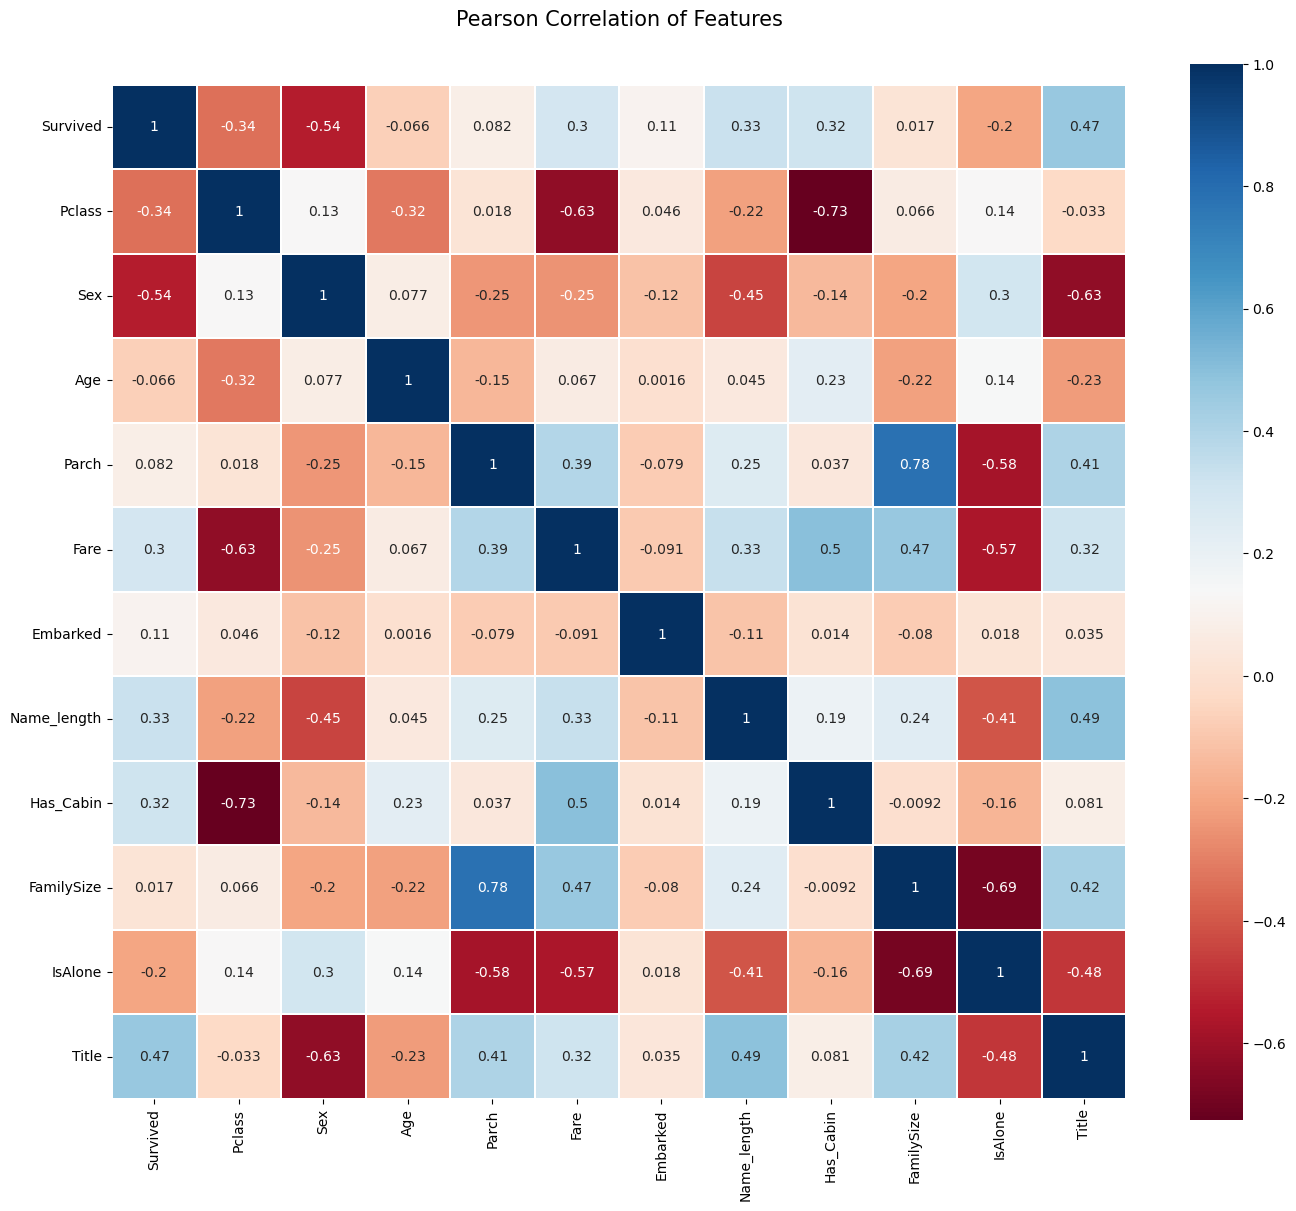

In [36]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.tight_layout()
plt.show()

피어슨 상관 관계에서 알 수 있는 한 가지는, 서로 강하게 상관되어 있는 피처가 많지 않다는 점.  
-> 훈련 데이터에 중복되거나 불필요한 정보가 많지 않다는 의미  
가장 상관 관계가 높은 FamilySize와 Parch 그대로 사용할 예정이다. 

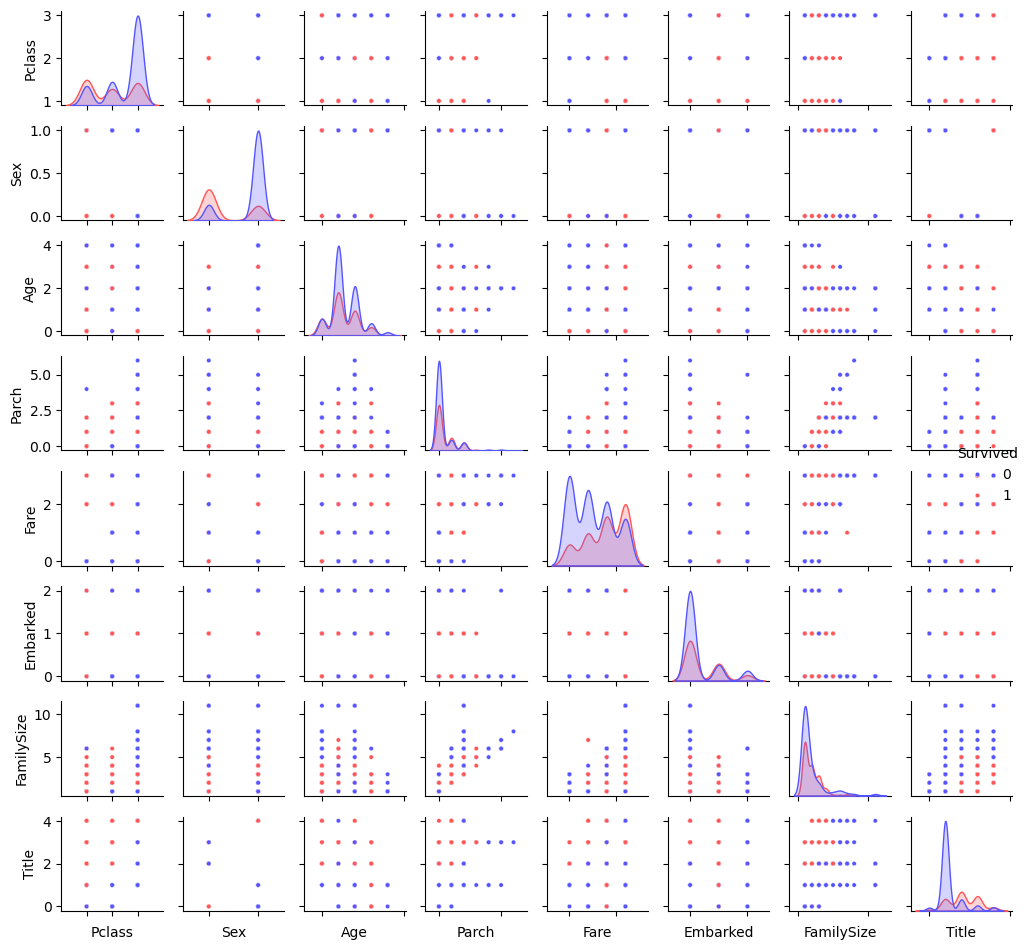

In [37]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])
plt.tight_layout()
plt.show()

## Ensembling & Stacking models

In [38]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 
NFOLDS = 5 
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED) # n_folds -> n_splits=NFOLDS

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [47]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        # fk가 객체라서 반복할 수 없다 -> split 사용
        x_tr = x_train[train_index] # 훈련 데이터 
        y_tr = y_train[train_index]
        x_te = x_train[test_index] # 검증 데이터 

        clf.train(x_tr, y_tr) # 모델 학습

        oof_train[test_index] = clf.predict(x_te) # 검증 데이터 예측값 저장
        oof_test_skf[i, :] = clf.predict(x_test) # 데이터셋 예측

    oof_test[:] = oof_test_skf.mean(axis=0) # 테스트셋 예측 평균내서 최종 결과 생성
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
# 다음 모델의 학습 입력으로 사용될 훈련 예측 결과 반환
# 다음 모델의 예측 입력으로 사용될 테스트 결과 반환

## Generating our Base First-Level Models

- Random Forest classifier
- Extra Trees classifier
- AdaBoost classifer
- Gradient Boosting classifer
- Support Vector Machine

In [40]:
# Random Forest Parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [42]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

rf = SklearnHelper(clf=RandomForestClassifier, seed=0, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=0, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=0, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=0, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=0, params=svc_params)

In [43]:
y_train = train['Survived'].ravel() # .ravel() : 1차원 배열로 펼쳐주는 역할
train = train.drop(['Survived'], axis=1)
x_train = train.values 
x_test = test.values 

1단계 예측 결과를 생성 -> 메타 모델의 입력값으로 넣는다.

In [48]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


첫 단계 분류기들이 학습을 마치면, 각 분류기가 학습에 사용한 피처들의 중요도(feature importance)를 쉽게 확인할 수 있따.

In [50]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.11005534 0.21237056 0.03051077 0.01960905 0.04640145 0.02757148
 0.12745739 0.05055368 0.06992436 0.01037514 0.29517077]
[0.1278387  0.36549568 0.0259094  0.01576704 0.05618901 0.0276732
 0.04494328 0.08004984 0.04567418 0.01911997 0.19133969]
[0.07003555 0.03056034 0.07903046 0.         0.00550584 0.02064972
 0.23325771 0.03105943 0.38091673 0.00609665 0.14288757]
[0.1413888  0.00969542 0.05564272 0.01197925 0.05674287 0.02865207
 0.16676488 0.03645898 0.08528288 0.00562727 0.40176486]


In [66]:
# rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
#   ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
# et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
#   ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
# ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
#   ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
# gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
#   ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [67]:
models = [rf, et, ada, gb]
features_list = []

for model in models:
    features_list.append(model.clf.feature_importances_)

rf_features, et_features, ada_features, gb_features = features_list

print(rf_features)
print(et_features)
print(ada_features)
print(gb_features)

[0.11005534 0.21237056 0.03051077 0.01960905 0.04640145 0.02757148
 0.12745739 0.05055368 0.06992436 0.01037514 0.29517077]
[0.1278387  0.36549568 0.0259094  0.01576704 0.05618901 0.0276732
 0.04494328 0.08004984 0.04567418 0.01911997 0.19133969]
[0.07003555 0.03056034 0.07903046 0.         0.00550584 0.02064972
 0.23325771 0.03105943 0.38091673 0.00609665 0.14288757]
[0.1413888  0.00969542 0.05564272 0.01197925 0.05674287 0.02865207
 0.16676488 0.03645898 0.08528288 0.00562727 0.40176486]


각 모델별 feature importance 리스트를 모아서 데이터프레임으로 만들고, 시각화

In [69]:
cols = train.columns.values
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

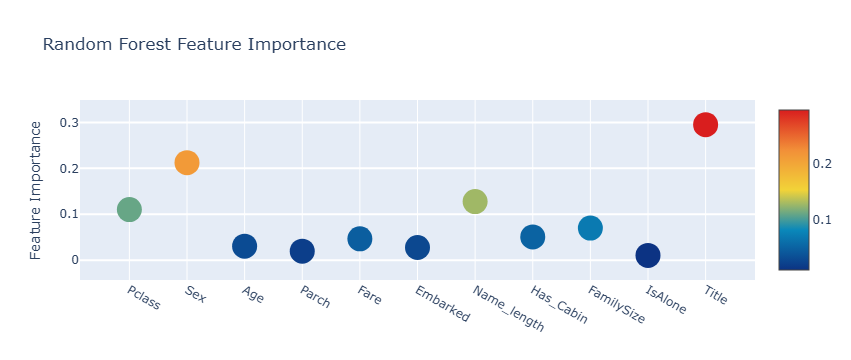

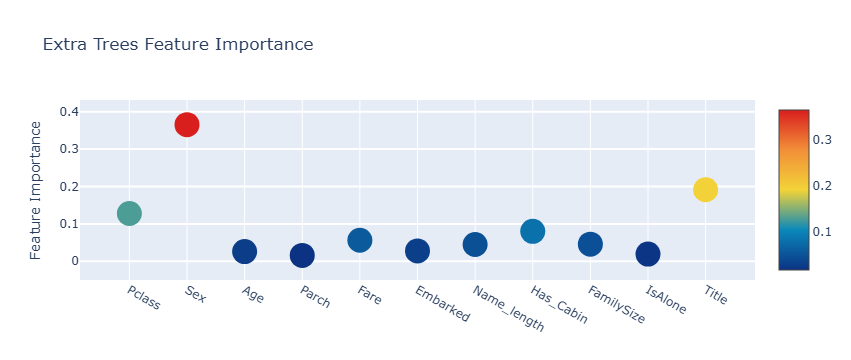

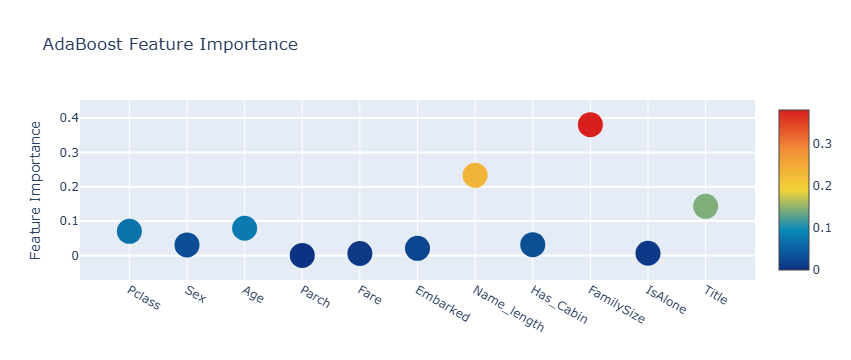

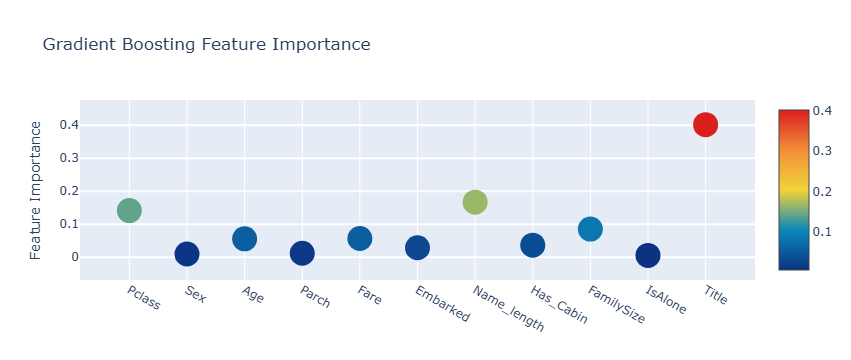

In [70]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [74]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.110055,0.127839,0.070036,0.141389
1,Sex,0.212371,0.365496,0.030560,0.009695
2,Age,0.030511,0.025909,0.079030,0.055643
3,Parch,0.019609,0.015767,0.000000,0.011979
4,Fare,0.046401,0.056189,0.005506,0.056743
5,Embarked,0.027571,0.027673,0.020650,0.028652
6,Name_length,0.127457,0.044943,0.233258,0.166765
7,Has_Cabin,0.050554,0.080050,0.031059,0.036459
8,FamilySize,0.069924,0.045674,0.380917,0.085283
9,IsAlone,0.010375,0.019120,0.006097,0.005627


In [75]:
feature_dataframe['mean'] = feature_dataframe.select_dtypes(include=[float, int]).mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.110055,0.127839,0.070036,0.141389,0.112330
1,Sex,0.212371,0.365496,0.030560,0.009695,0.154531
2,Age,0.030511,0.025909,0.079030,0.055643,0.047773


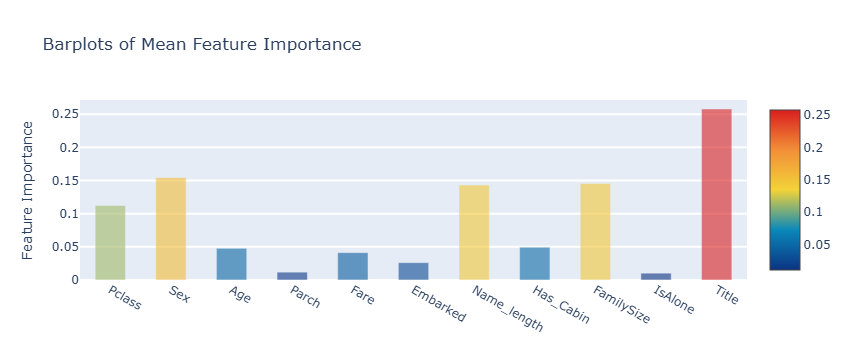

In [76]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

이제 첫 번째 단계의 예측값들을 얻었으니, 이를 사실상 다음 단계 분류기(메타 모델)를 위한 새로운 학습 데이터의 특성 세트  
이것이 스태킹(ensemble stacking) 기법의 핵심 아이디어 중 하나이다.

In [78]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
886,0.0,0.0,0.0,0.0
887,1.0,1.0,1.0,1.0
888,0.0,1.0,1.0,1.0
889,0.0,0.0,1.0,1.0


### Correlation Heatmap of the Second Level Training set

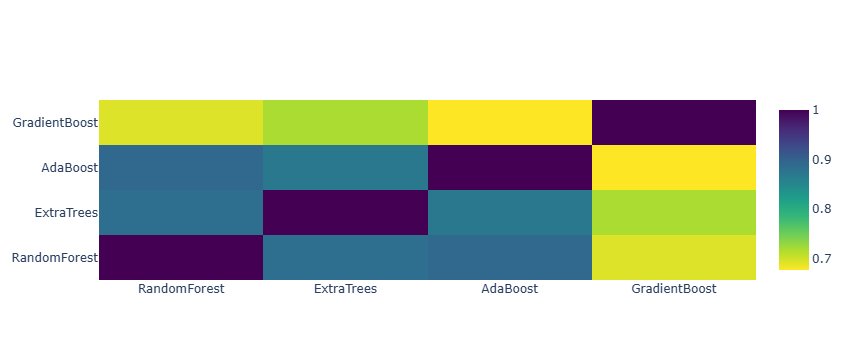

In [79]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

서로 상관관계가 낮은 (=서로 다르게 학습된) 모델을 조합했을 때 더 좋은 성능이 나온다.  
서로 다른 관점에서 문제를 바라보는 독립적인 모델을 함께 쓰면 예측력이 더 좋아진다는 말이다.

In [80]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

첫 번째 단계에서 학습한 train, test 예측값들을 합쳐서 x_train, x_train 데이터로 만들었다.  
두 번째 학습 모델로는 XGBoost를 사용한다.

In [81]:
gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [85]:
# Submission File 생성
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("./StackingSubmission.csv", index=False)